In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.8 MB/s eta 0:00:00


In [2]:
# Data Handling and Processing
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import pywt
from scipy import stats
import wfdb

In [3]:
base_dir = '/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0'

In [4]:
def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/{name}"  
        
        try:
            record = wfdb.rdrecord(record_name, channels=[0]) 
            annotation = wfdb.rdann(record_name, 'atr')
            
            signal = record.p_signal.flatten()  
            # print(signal)
            # print(f"The count of the dat file: {len(signal)}")
            
            # print(len(signal))
            fs = record.fs  
            # print(fs) # 360 hz original
            
            # Get R-peak locations and annotations
            r_peaks = annotation.sample 
            # print(r_peaks)

            labels = annotation.symbol
            window_size = 257
            
            for i in range(1, len(r_peaks) - 1):  
                start = max(0, r_peaks[i] - window_size // 2)
                end = min(len(signal), r_peaks[i] + window_size // 2 )
                beat = signal[start:end + 1]

                if len(beat) == 257:
                    beats.append(beat)
                    beat_labels.append(labels[i])
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return beat_labels, beats

record_list = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
               '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
               '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
               '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
               '222', '223', '228', '230', '231', '232', '233', '234']

labels, extracted_beats = extract_beats_from_multiple_files(record_list)
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")

Total beats extracted: 112529
Total labels: 112529
Length of first beat: 257


In [5]:
print("Converting beats to array...")
signals = np.array(extracted_beats)  

print("Creating DataFrame with 257 columns...")
signal_columns = [f"signal_{i}" for i in range(257)] 
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(257)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 257 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (112529, 258)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0    -0.285    -0.280    -0.300    -0.300    -0.305    -0.295    -0.300   
1    -0.335    -0.335    -0.330    -0.325    -0.345    -0.350    -0.345   
2    -0.355    -0.360    -0.355    -0.365    -0.355    -0.350    -0.340   
3    -0.330    -0.315    -0.320    -0.320    -0.330    -0.345    -0.340   
4    -0.320    -0.315    -0.335    -0.335    -0.345    -0.335    -0.325   

   signal_7  signal_8  signal_9  ...  signal_248  signal_249  signal_250  \
0    -0.310    -0.310    -0.305  ...      -0.330      -0.330      -0.320   
1    -0.335    -0.330    -0.330  ...      -0.300      -0.300      -0.310   
2    -0.355    -0.350    -0.365  ...      -0.295      -0.295      -0.290   
3    -0.335    -0.330    -0.335  ...      -0.305      -0.310      -0.315   
4   

In [6]:
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

label_column = df.iloc[:, -1]  
df = df.iloc[:, :-1].astype(float) 
df["qrs_label"] = label_column 

df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112529 entries, 0 to 112528
Columns: 258 entries, signal_0 to qrs_label
dtypes: float64(257), object(1)
memory usage: 221.5+ MB
None


In [7]:
data = pd.read_csv('/kaggle/working/mitbih_beats_expanded.csv')

data.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255,signal_256,qrs_label
0,-0.285,-0.280,-0.300,-0.300,-0.305,-0.295,-0.300,-0.310,-0.310,-0.305,...,-0.330,-0.330,-0.320,-0.310,-0.300,-0.300,-0.320,-0.320,-0.315,N
1,-0.335,-0.335,-0.330,-0.325,-0.345,-0.350,-0.345,-0.335,-0.330,-0.330,...,-0.300,-0.300,-0.310,-0.310,-0.310,-0.315,-0.300,-0.305,-0.315,N
2,-0.355,-0.360,-0.355,-0.365,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,...,-0.295,-0.295,-0.290,-0.280,-0.290,-0.295,-0.310,-0.295,-0.285,N
3,-0.330,-0.315,-0.320,-0.320,-0.330,-0.345,-0.340,-0.335,-0.330,-0.335,...,-0.305,-0.310,-0.315,-0.320,-0.315,-0.305,-0.305,-0.295,-0.310,N
4,-0.320,-0.315,-0.335,-0.335,-0.345,-0.335,-0.325,-0.330,-0.315,-0.335,...,-0.290,-0.310,-0.295,-0.285,-0.280,-0.300,-0.290,-0.295,-0.290,N


In [8]:
data.iloc[:, -1].unique()

array(['N', 'A', 'V', '~', '|', 'Q', '/', 'f', '+', 'x', 'F', 'j', 'L',
       'a', 'J', 'R', '[', '!', ']', 'E', 'S', '"', 'e'], dtype=object)

In [9]:
data.iloc[:, -1].value_counts().reset_index()

,qrs_label,count
0,N,75003
1,L,8070
2,R,7254
3,V,7129
4,/,7022
5,A,2544
6,+,1244
7,f,982
8,F,802
9,~,614


In [10]:
# Define AAMI class mapping
AAMI_MAPPING = {
    "N": "Normal", "L": "Normal", "R": "Normal", "e": "Normal", "j": "Normal",
    "A": "SVEB", "a": "SVEB", "J": "SVEB", "S": "SVEB",
    "V": "VEB", "E": "VEB",
    "F": "Fusion",
    "/": "Unknown", "f": "Unknown", "Q": "Unknown"
}

# Map QRS labels to AAMI categories
data["AAMI_Class"] = data["qrs_label"].map(AAMI_MAPPING)

# Drop rows where AAMI_Class is NaN (labels not in mapping)
data = data.dropna(subset=["AAMI_Class"])

# Convert AAMI classes to numerical encoding
encoding_map = {"Normal": 0, "SVEB": 1, "VEB": 2, "Fusion": 3, "Unknown": 4}
data["AAMI_Class_Encoded"] = data["AAMI_Class"].map(encoding_map)

# Save processed file
data.to_csv("processed_qrs_labels.csv", index=False)

# Show final value counts
print(data["AAMI_Class_Encoded"].value_counts())


AAMI_Class_Encoded
0    90572
4     8037
2     7235
1     2779
3      802
Name: count, dtype: int64


| Heart rhythm label (proportion) | Content description               | Include subcategories | Subclass label description                  |
|---------------------------------|----------------------------------|----------------------|---------------------------------------------|
| **N**                     | Normal heart rhythm              | L                    | Left bundle branch block                   |
|                                 |                                  | N                    | Normal ECG beat                            |
|                                 |                                  | R                    | Right bundle branch block                  |
|                                 |                                  | e                    | Atrial escape                              |
|                                 |                                  | j                    | Borderline escape                          |
| **S**                      | Supraventricular abnormalities   | A                    | Atrial premature beats                     |
|                                 |                                  | J                    | Borderline premature beats                 |
|                                 |                                  | S                    | Supraventricular premature beats           |
|                                 |                                  | a                    | Abnormal atrial premature beats            |
| **V**                      | Ventricular escape               | E                    | Ventricular escape beat                    |
|                                 |                                  | V                    | Ventricular premature beats                |
| **F**                      | Fusion Heartbeat                 | F                    | Ventricular fusion heartbeat               |
| **Q**                           | Unknown ECG beat                 | /                    | Pacing heartbeat                           |
|                                 |                                  | Q                   | Uncategorized ECG beat                     |
|                                 |                                  | f                    | Pacing and normal fusion heartbeat         |


| AAMI Class                         | Calculated Count | Paper Count | Difference |
|------------------------------------|-----------------|-------------|------------|
| **Normal (N class)**               | 90,572          | 90,593      | -21        |
| **Supraventricular Ectopic (SVEB)** | 2,779           | 2,781       | -2         |
| **Ventricular Ectopic (VEB)**       | 7,235           | 7,235       | 0          |
| **Fusion Beat (F class)**           | 802             | 802         | 0          |
| **Unknown (Q class)**               | 8,037           | 8,040       | -3         |
| **Total**                           | 109,425         | 109,451     | -26        |


In [11]:
data = data.drop(columns=["qrs_label", "AAMI_Class"])
data = data.rename(columns={"AAMI_Class_Encoded": "qrs_label"})
data.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255,signal_256,qrs_label
0,-0.285,-0.280,-0.300,-0.300,-0.305,-0.295,-0.300,-0.310,-0.310,-0.305,...,-0.330,-0.330,-0.320,-0.310,-0.300,-0.300,-0.320,-0.320,-0.315,0
1,-0.335,-0.335,-0.330,-0.325,-0.345,-0.350,-0.345,-0.335,-0.330,-0.330,...,-0.300,-0.300,-0.310,-0.310,-0.310,-0.315,-0.300,-0.305,-0.315,0
2,-0.355,-0.360,-0.355,-0.365,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,...,-0.295,-0.295,-0.290,-0.280,-0.290,-0.295,-0.310,-0.295,-0.285,0
3,-0.330,-0.315,-0.320,-0.320,-0.330,-0.345,-0.340,-0.335,-0.330,-0.335,...,-0.305,-0.310,-0.315,-0.320,-0.315,-0.305,-0.305,-0.295,-0.310,0
4,-0.320,-0.315,-0.335,-0.335,-0.345,-0.335,-0.325,-0.330,-0.315,-0.335,...,-0.290,-0.310,-0.295,-0.285,-0.280,-0.300,-0.290,-0.295,-0.290,0


In [12]:
X = data.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_247,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255,signal_256
0,-0.285,-0.280,-0.300,-0.300,-0.305,-0.295,-0.300,-0.310,-0.310,-0.305,...,-0.32,-0.330,-0.330,-0.320,-0.310,-0.300,-0.300,-0.320,-0.320,-0.315
1,-0.335,-0.335,-0.330,-0.325,-0.345,-0.350,-0.345,-0.335,-0.330,-0.330,...,-0.30,-0.300,-0.300,-0.310,-0.310,-0.310,-0.315,-0.300,-0.305,-0.315
2,-0.355,-0.360,-0.355,-0.365,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,...,-0.29,-0.295,-0.295,-0.290,-0.280,-0.290,-0.295,-0.310,-0.295,-0.285
3,-0.330,-0.315,-0.320,-0.320,-0.330,-0.345,-0.340,-0.335,-0.330,-0.335,...,-0.31,-0.305,-0.310,-0.315,-0.320,-0.315,-0.305,-0.305,-0.295,-0.310
4,-0.320,-0.315,-0.335,-0.335,-0.345,-0.335,-0.325,-0.330,-0.315,-0.335,...,-0.29,-0.290,-0.310,-0.295,-0.285,-0.280,-0.300,-0.290,-0.295,-0.290


In [13]:
y = data.iloc[:, -1]
y

0         0
1         0
2         0
3         0
4         0
         ..
112524    0
112525    0
112526    0
112527    0
112528    0
Name: qrs_label, Length: 109425, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=0.25, 
                                                      random_state=42, 
                                                      stratify=y_train)

In [15]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (65655, 257)
The shape of X_test: (21885, 257)
The shape of X_valid: (21885, 257)
The length of y_train: 65655
The length of y_test: 21885
The shape of y_valid: 21885


In [16]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))

(65655, 257, 1)
<class 'numpy.ndarray'>
(21885, 257, 1)
<class 'numpy.ndarray'>
(21885, 257, 1)
<class 'numpy.ndarray'>


In [17]:
import tensorflow as tf
num_classes = 5
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("Train y shape:", y_train.shape)
print("Valid y shape:", y_valid.shape)
print("Test y shape:", y_test.shape)

Train y shape: (65655, 5)
Valid y shape: (21885, 5)
Test y shape: (21885, 5)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy.signal import stft
import os
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Custom CONV-FAN Block (1:1:1 GELU, Sine, Cosine activations)
def conv_fan_block(filters, kernel_size, input_tensor):
    filters_per_act = filters // 3
    
    gelu_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    gelu_branch = layers.Activation('gelu')(gelu_branch)
    
    sine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    sine_branch = layers.Activation(tf.math.sin)(sine_branch)
    
    cosine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    cosine_branch = layers.Activation(tf.math.cos)(cosine_branch)
    
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# Custom FC-FAN Block (4:1:1 GELU, Sine, Cosine activations)
def fc_fan_block(units, input_tensor):
    units_gelu = int(units * 4 / 6)
    units_sine = int(units * 1 / 6)
    units_cosine = int(units * 1 / 6)
    
    gelu_branch = layers.Dense(units_gelu, activation='gelu')(input_tensor)
    sine_branch = layers.Dense(units_sine, activation=tf.math.sin)(input_tensor)
    cosine_branch = layers.Dense(units_cosine, activation=tf.math.cos)(input_tensor)
    
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# CFAN Model for MIT-BIH
def build_cfan_model(input_shape=(257, 1), num_classes=5):
    inputs = layers.Input(shape=input_shape)
    
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=inputs)
    
    skip = layers.Conv1D(96, kernel_size=64, padding='same', activation='relu')(inputs)
    x = layers.Add()([x, skip])
    x = layers.Activation('relu')(x)
    
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=x)
    
    x = layers.GlobalAveragePooling1D()(x)
    
    x = fc_fan_block(units=120, input_tensor=x)
    x = fc_fan_block(units=84, input_tensor=x)
    
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

Epoch 1/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 303ms/step - accuracy: 0.7845 - loss: 0.6956 - val_accuracy: 0.8873 - val_loss: 0.3842
Epoch 2/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9064 - loss: 0.3230 - val_accuracy: 0.9379 - val_loss: 0.2289
Epoch 3/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9389 - loss: 0.2252 - val_accuracy: 0.9510 - val_loss: 0.1782
Epoch 4/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9492 - loss: 0.1797 - val_accuracy: 0.9602 - val_loss: 0.1482
Epoch 5/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9567 - loss: 0.1552 - val_accuracy: 0.9625 - val_loss: 0.1361
Epoch 6/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9619 - loss: 0.1349 - val_accuracy: 0.9678 - val_loss: 0.1126
Epoch 7/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9669 - loss: 0.1197 - val_accuracy: 0.9686 - val_loss: 0.1074
Epoch 8/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9696 - loss: 0.1063 - 

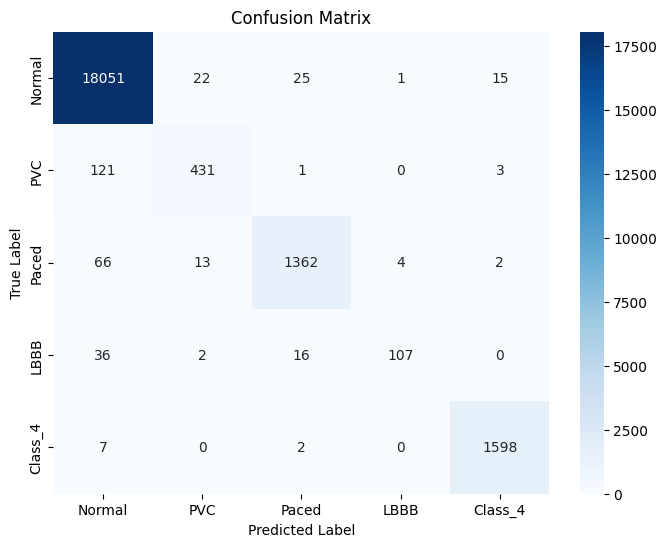

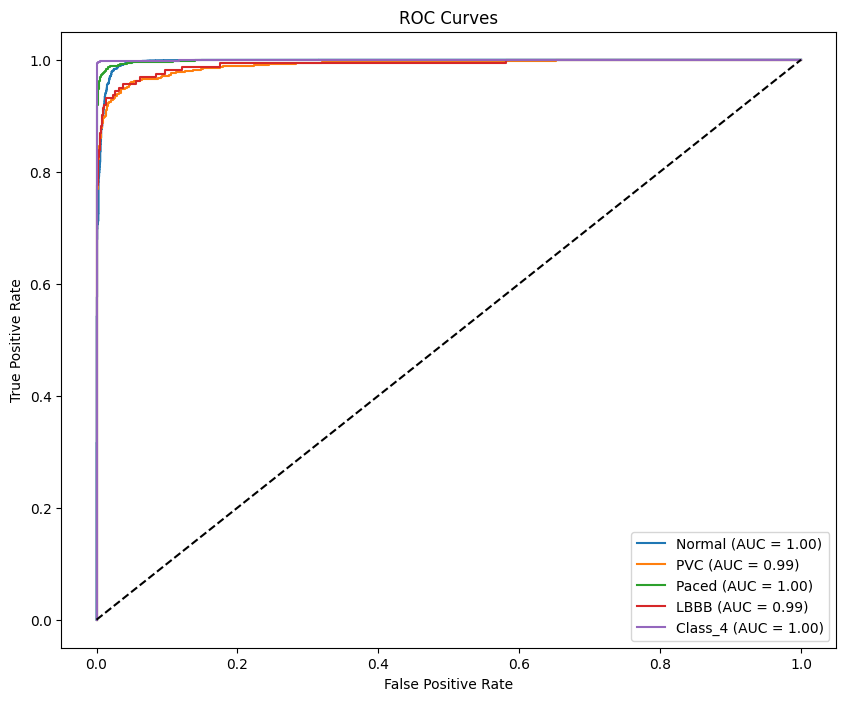

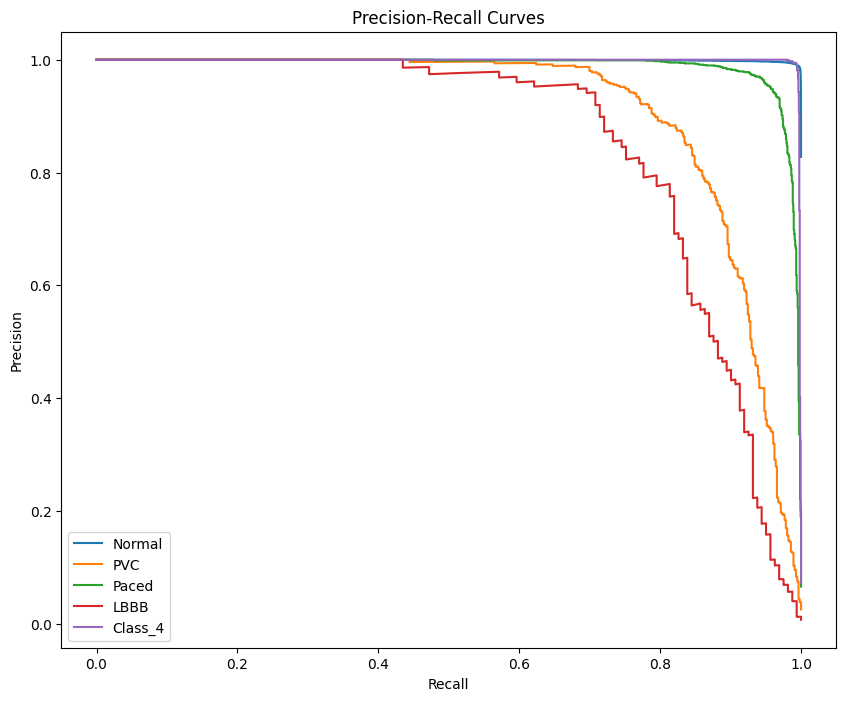

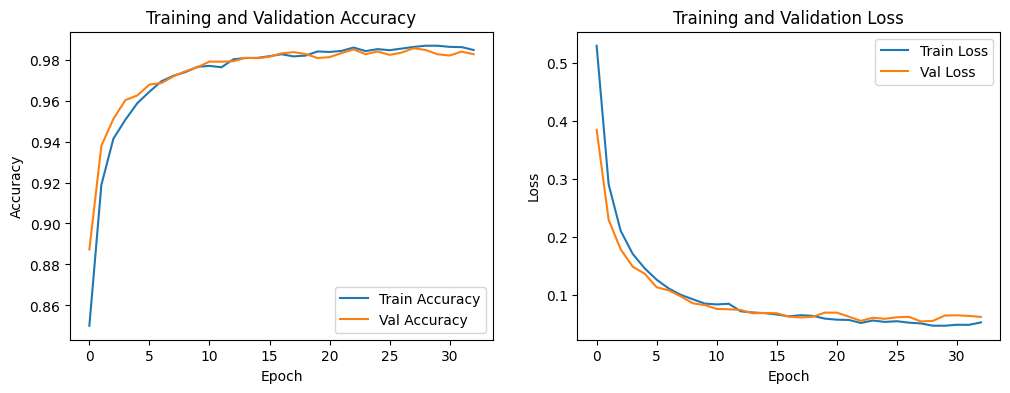

In [19]:
# Bootstrap CI calculation
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    bootstrapped_scores = []
    n = len(data)
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n, n)
        score = np.mean(data[indices])
        bootstrapped_scores.append(score)
    lower = np.percentile(bootstrapped_scores, 100 * alpha / 2)
    upper = np.percentile(bootstrapped_scores, 100 * (1 - alpha / 2))
    return lower, upper

# Find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    return thresholds[optimal_idx]

# Comprehensive evaluation function
def evaluate_model(model, X_test, y_test, class_names=['Normal', 'PVC', 'Paced', 'LBBB']):
    y_pred_proba = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    n_classes = y_test.shape[1]
    
    # Ensure class_names matches n_classes
    if len(class_names) != n_classes:
        print(f"Warning: Number of class names ({len(class_names)}) doesn't match number of classes ({n_classes})")
        # Extend or truncate class_names to match n_classes
        if len(class_names) < n_classes:
            class_names = class_names + [f'Class_{i}' for i in range(len(class_names), n_classes)]
        else:
            class_names = class_names[:n_classes]
    
    optimal_thresholds = [find_optimal_threshold(y_test[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    primary_threshold = 0.5
    
    y_pred = (y_pred_proba >= primary_threshold).astype(int)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    accuracy = np.mean(y_pred_labels == y_true)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='macro')
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='weighted')
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    print("\nModel Performance on Internal Test Set")
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro Precision: {prec_macro:.4f}")
    print(f"Macro Recall: {rec_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Weighted Precision: {prec_weighted:.4f}")
    print(f"Weighted Recall: {rec_weighted:.4f}")
    print(f"Macro AUC: {auc_macro:.4f}")
    
    print("\nPer-Class Metrics (Threshold = 0.5):")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'Specificity':<12} {'F1-Score':<10} {'AUC':<10}")
    print("-" * 65)
    
    per_class_metrics = []
    for i in range(n_classes):
        true_binary = (y_true == i).astype(int)
        pred_binary = (y_pred_labels == i).astype(int)
        proba_binary = y_pred_proba[:, i]
        
        tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(true_binary, proba_binary)
        
        prec_lower, prec_upper = bootstrap_ci(true_binary[pred_binary == 1]) if np.sum(pred_binary == 1) > 0 else (0, 0)
        rec_lower, rec_upper = bootstrap_ci(true_binary[pred_binary == 1]) if np.sum(pred_binary == 1) > 0 else (0, 0)
        
        per_class_metrics.append((precision, recall, specificity, f1, auc))
        print(f"{class_names[i]:<10} {precision:<10.4f} {recall:<10.4f} {specificity:<12.4f} {f1:<10.4f} {auc:<10.4f}")
        print(f"{'':<10} ({prec_lower:.2f}-{prec_upper:.2f}) ({rec_lower:.2f}-{rec_upper:.2f})")
    
    print(f"\nOperating Point: Primary decision threshold = {primary_threshold}")
    print(f"Optimal thresholds per class (Youden's J): {optimal_thresholds}")
    print("95% Confidence Intervals reported using bootstrapping method")
    
    # Visualizations
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        auc = per_class_metrics[i][4]
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.show()

# Modified training function
def train_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    n_classes = y_train.shape[1]  # Get number of classes from training data
    model = build_cfan_model(num_classes=n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    batch_size = 995
    max_epochs = 300
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=max_epochs,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=1)
    
    evaluate_model(model, X_test, y_test)
    
    return model, history

if __name__ == "__main__":
    
    model, history = train_model(X_train, y_train, X_valid, y_valid, X_test, y_test)
    # Training history plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

## Refrence

https://www.researchgate.net/figure/AAMI-arrhythmia-classification-labeling-standard_tbl2_347133776